In [ ]:
import numpy as np
import pandas as pd
import cv2
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os  # For path manipulation
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_images(image_paths, img_dir, img_size=(128, 128)):
    """Loads and preprocesses images, handling missing files."""
    images = []
    valid_paths = []
    for img_name in image_paths:
        img_path = os.path.join(img_dir, img_name)
        if os.path.exists(img_path):
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = img / 255.0
                images.append(img)
                valid_paths.append(img_path)
            except:
                print(f"Error loading image: {img_path}")
        else:
            print(f"Image not found: {img_path}")
    return np.array(images), valid_paths


def fast_pca(data, n_components):
    """Implements Fast Principal Component Analysis."""
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data)
    return transformed_data, pca


def train_and_evaluate_svm(X_train, X_test, y_train, y_test, kernel_type='linear'):
    """Trains and evaluates an SVM classifier."""

    if kernel_type == 'linear':
        model = svm.SVC(kernel='linear', probability=True, C=1.0)
    elif kernel_type == 'poly':
        model = svm.SVC(kernel='poly', degree=3, probability=True)
    elif kernel_type == 'rbf':
        model = svm.SVC(kernel='rbf', gamma='scale', probability=True)
    elif kernel_type == 'sigmoid':
        model = svm.SVC(kernel='sigmoid', probability=True)
    else:
        raise ValueError("Invalid kernel type specified.")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report, model


def predict_fn(images, pca_model, svm_model):
    # Preprocess images: flatten and normalize
    processed_images = []
    for img in images:
        # Normalize (assuming images are not already normalized)
        img = img / 255.0
        img_flat = img.reshape(1, -1)  # Flatten
        processed_images.append(img_flat)
    processed_images = np.vstack(processed_images)

    # Apply PCA transformation
    images_reduced = pca_model.transform(processed_images)

    # Get probabilities from SVM
    probs = svm_model.predict_proba(images_reduced)
    return probs


def explain_image(image, pca_model, svm_model, num_samples=1000, top_labels=2):
    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Ensure image is in the correct format (not flattened, 128x128x3)
    image = image.reshape(128, 128, 3) if image.shape != (
        128, 128, 3) else image

    # Define segmentation function (e.g., quickshift)
    segmenter = SegmentationAlgorithm(
        'quickshift', kernel_size=4, max_dist=200, ratio=0.2)

    # Explain the prediction
    explanation = explainer.explain_instance(
        image,
        lambda x: predict_fn(x, pca_model, svm_model),
        top_labels=top_labels,
        hide_color=0,
        num_samples=num_samples,
        segmentation_fn=segmenter
    )

    # Visualize the explanation
    from skimage.segmentation import mark_boundaries
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True
    )
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(image, mask))
    plt.title(f"LIME Explanation for {svm_model.kernel} Kernel")
    plt.show()

    return explanation


# --- Updated Example Usage with Sampling ---
data = pd.read_csv('/home/ozien/Untitled Folder/XAI/Data/new_labels.csv')

# <--  SET THIS CORRECTLY!
img_dir = '/home/ozien/Untitled Folder/XAI/Data/resized_images'

# --- Sampling ---
sample_size = 0.1  # e.g., 0.1 for 10% of the data
data_sample = data.sample(frac=sample_size, random_state=42)  # Random sample

image_names = data_sample['Path'].values
labels = data_sample.iloc[:, 1:].values

images, image_paths = load_and_preprocess_images(image_names, img_dir)
X = images.reshape(images.shape[0], -1)
# target variable
# Assuming labels are in the second column onwards
# Adjust this if your labels are structured differently
y = labels[:, 10]  # Assuming the first column is the image name

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train_reduced, pca_model = fast_pca(X_train, n_components=100)
# Use transform, not fit_transform
X_test_reduced = pca_model.transform(X_test)

In [2]:
accuracy, report, model_linear = train_and_evaluate_svm(
    X_train_reduced, X_test_reduced, y_train, y_test, kernel_type='linear')
print(f"SVM with {'linear'} kernel:")
print(f"  Accuracy: {accuracy}")
print("  Classification Report:")
print(report)

SVM with linear kernel:
  Accuracy: 0.896887159533074
  Classification Report:
{'0': {'precision': 0.896887159533074, 'recall': 1.0, 'f1-score': 0.9456410256410256, 'support': 922.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 106.0}, 'accuracy': 0.896887159533074, 'macro avg': {'precision': 0.448443579766537, 'recall': 0.5, 'f1-score': 0.4728205128205128, 'support': 1028.0}, 'weighted avg': {'precision': 0.8044065769353057, 'recall': 0.896887159533074, 'f1-score': 0.8481332934251222, 'support': 1028.0}}


/home/ozien/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ozien/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ozien/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [3]:
accuracy, report, model_poly = train_and_evaluate_svm(
    X_train_reduced, X_test_reduced, y_train, y_test, kernel_type='poly')
print(f"SVM with {'poly'} kernel:")
print(f"  Accuracy: {accuracy}")
print("  Classification Report:")
print(report)

SVM with poly kernel:
  Accuracy: 0.896887159533074
  Classification Report:
{'0': {'precision': 0.896887159533074, 'recall': 1.0, 'f1-score': 0.9456410256410256, 'support': 922.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 106.0}, 'accuracy': 0.896887159533074, 'macro avg': {'precision': 0.448443579766537, 'recall': 0.5, 'f1-score': 0.4728205128205128, 'support': 1028.0}, 'weighted avg': {'precision': 0.8044065769353057, 'recall': 0.896887159533074, 'f1-score': 0.8481332934251222, 'support': 1028.0}}


/home/ozien/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ozien/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ozien/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [4]:
accuracy, report, model_rbf = train_and_evaluate_svm(
    X_train_reduced, X_test_reduced, y_train, y_test, kernel_type='rbf')
print(f"SVM with {'rbf'} kernel:")
print(f"  Accuracy: {accuracy}")
print("  Classification Report:")
print(report)

SVM with rbf kernel:
  Accuracy: 0.896887159533074
  Classification Report:
{'0': {'precision': 0.896887159533074, 'recall': 1.0, 'f1-score': 0.9456410256410256, 'support': 922.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 106.0}, 'accuracy': 0.896887159533074, 'macro avg': {'precision': 0.448443579766537, 'recall': 0.5, 'f1-score': 0.4728205128205128, 'support': 1028.0}, 'weighted avg': {'precision': 0.8044065769353057, 'recall': 0.896887159533074, 'f1-score': 0.8481332934251222, 'support': 1028.0}}


/home/ozien/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ozien/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ozien/anaconda3/envs/rapids-25.02/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

In [5]:
accuracy, report, model_sigmoid = train_and_evaluate_svm(
    X_train_reduced, X_test_reduced, y_train, y_test, kernel_type='sigmoid')
print(f"SVM with {'sigmoid'} kernel:")
print(f"  Accuracy: {accuracy}")
print("  Classification Report:")
print(report)

SVM with sigmoid kernel:
  Accuracy: 0.872568093385214
  Classification Report:
{'0': {'precision': 0.9031600407747197, 'recall': 0.9609544468546638, 'f1-score': 0.931161324224908, 'support': 922.0}, '1': {'precision': 0.23404255319148937, 'recall': 0.10377358490566038, 'f1-score': 0.1437908496732026, 'support': 106.0}, 'accuracy': 0.872568093385214, 'macro avg': {'precision': 0.5686012969831045, 'recall': 0.5323640158801621, 'f1-score': 0.5374760869490554, 'support': 1028.0}, 'weighted avg': {'precision': 0.8341654360239197, 'recall': 0.872568093385214, 'f1-score': 0.8499733180940902, 'support': 1028.0}}


Generating LIME explanation for linear kernel...


  0%|          | 0/1000 [00:00<?, ?it/s]

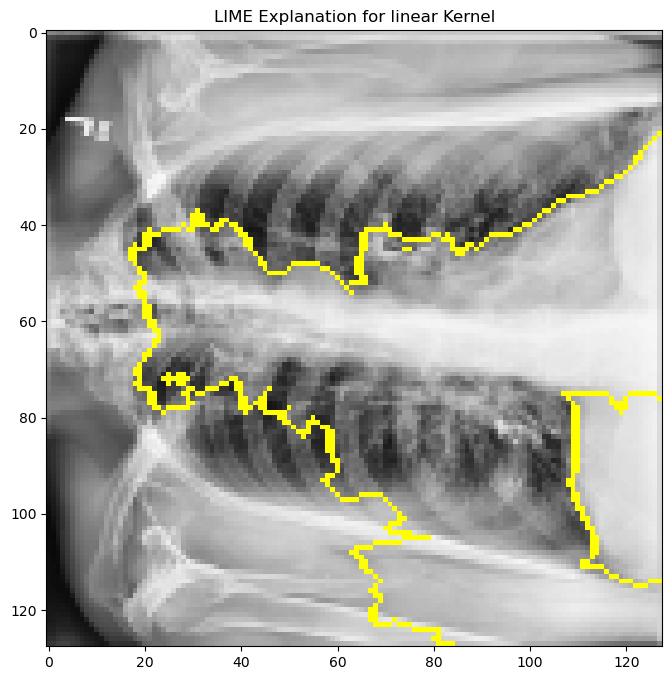

Generating LIME explanation for poly kernel...


  0%|          | 0/1000 [00:00<?, ?it/s]

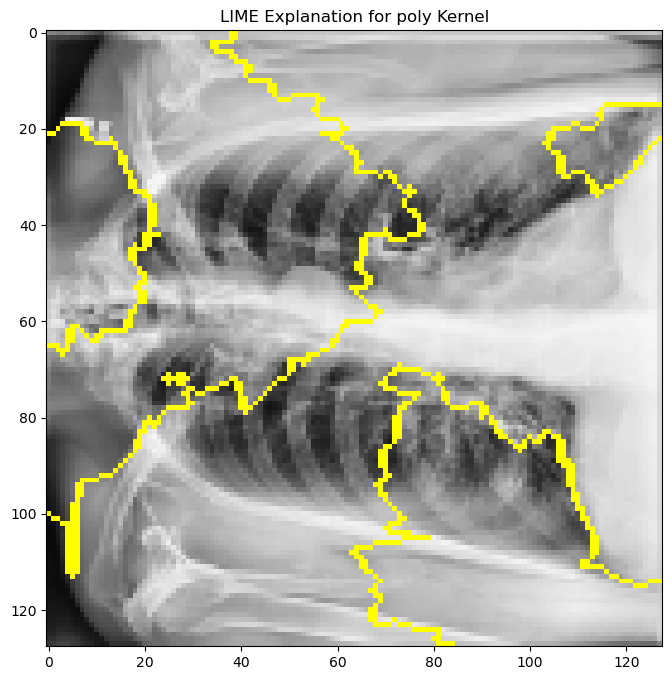

Generating LIME explanation for rbf kernel...


  0%|          | 0/1000 [00:00<?, ?it/s]

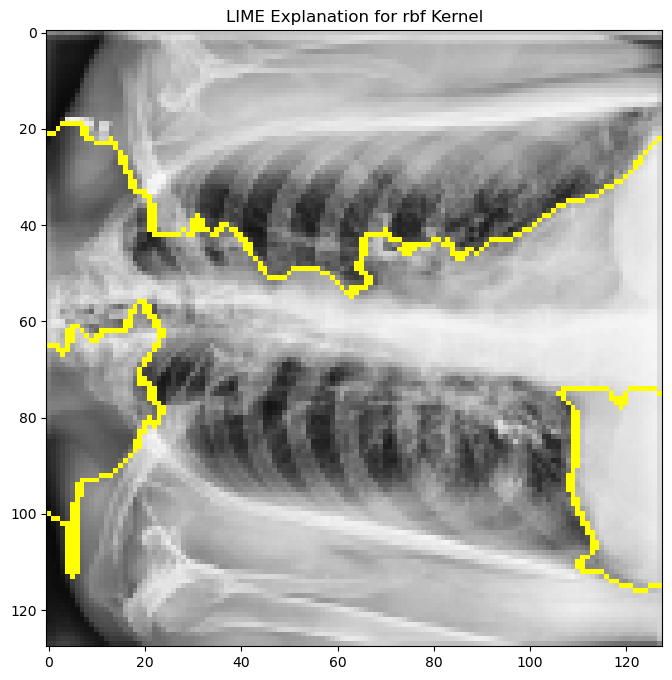

Generating LIME explanation for sigmoid kernel...


  0%|          | 0/1000 [00:00<?, ?it/s]

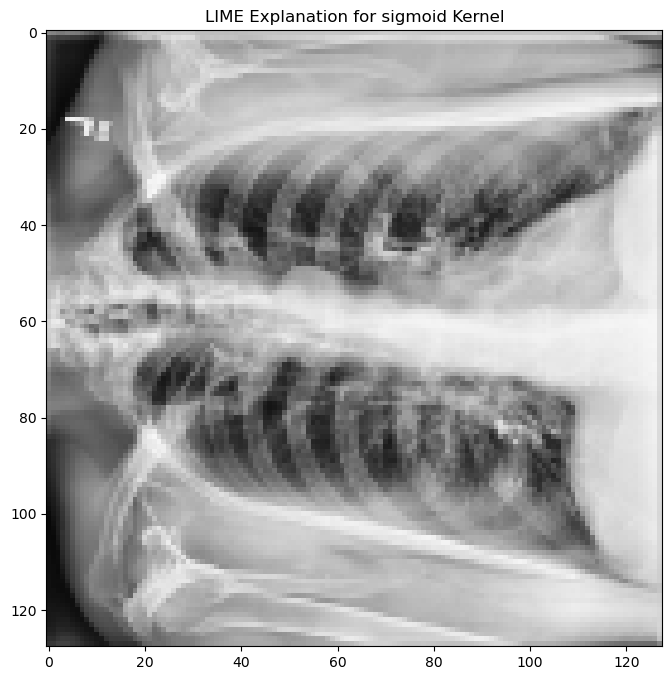

In [6]:
# Select an index from the test set
test_idx = 0  # Change this to explain different images

# Retrieve the original image (before PCA)
# Assuming `images` contains the original preprocessed images
original_image = images[test_idx]  # Shape: (128, 128, 3)

# Explain for each model
models = {
    'linear': model_linear,
    'poly': model_poly,
    'rbf': model_rbf,
    'sigmoid': model_sigmoid
}

for kernel, model in models.items():
    print(f"Generating LIME explanation for {kernel} kernel...")
    explanation = explain_image(
        original_image, pca_model, model, num_samples=1000, top_labels=2)

In [ ]:
# visualize results of each svm model
def visualize_model_results(model, X_test, y_test):
    """Visualizes the results of the SVM model."""
    y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title(f'SVM Model Results')
    plt.show()
# Visualize results for each model
for kernel, model in models.items():
    print(f"Visualizing results for {kernel} kernel...")
    visualize_model_results(model, X_test_reduced, y_test)


In [ ]:
# Save the models for future use
from sklearn.preprocessing import StandardScaler
import joblib
joblib.dump(model_linear, 'model_linear.pkl')
joblib.dump(model_poly, 'model_poly.pkl')
joblib.dump(model_rbf, 'model_rbf.pkl')
joblib.dump(model_sigmoid, 'model_sigmoid.pkl')
# Save the PCA model
joblib.dump(pca_model, 'pca_model.pkl')
# Save the scaler
scaler = StandardScaler()
scaler.fit(X_train)
joblib.dump(scaler, 'scaler.pkl')